# Import libraries

In [ ]:
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import os

# v0.2 imports
import mplfinance as fplt
import matplotlib.pyplot as plt

# v0.4 imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, GRU, SimpleRNN, Input, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# v0.5 imports
import pmdarima as pm
import datetime
import itertools

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# set seed to get stable results in training/testing run
np.random.seed(314)

In [ ]:
def load_data(download, ticker, TEST_START='2020-01-01', TEST_END='2023-01-01', scale=True, shuffle=True, dropNaN=True, split_by_ratio=True, split_by_date=False, split_date=None, test_size=0.2, feature_columns=["adjclose", "volume", "open", "high", "low"], n_steps=30):
    """
    Loads data from yahoo finance, then scaling, shuffle, and normalization.
    :param ticker: (str/pd.DataFrame), the ticker you want to load, like META, AAPL,...
    :param TEST_START: str, the start date of the test data (format: "YYYY-MM-DD")
    :param TEST_END: str, the end date of the test data (format: "YYYY-MM-DD")
    :param scale: whether to scale prices between 0 and 1, default is True
    :param shuffle: bool, whether to shuffle the dataset (both training and testing), default is True
    :param dropNaN: bool, whether to drop NaN values, default is True
    :param split_by_date: bool, whether to split the data into training and testing by date, default is True
    :param test_size: ratio of test data to train data, default is 0.2 (80% for training and 20% for testing)
    :param feature_columns: the list of features to feed into the model, default is everything grabbed from yahoo_fin
    :return:
    """

    # ------------------------------------------------------------------------------------------------#
    # Ticket to csv file, put it into folder dataset
    if download:
        ticker_data_filename = os.path.join("dataset", f"{ticker}_{TEST_START}_{TEST_END}.csv")
        ## a, see if ticker is already a loaded stock from yahoo finance
        if os.path.exists(ticker_data_filename):
            print(f'Loading data from {ticker_data_filename}')
            # read csv file, take date column as index
            df = pd.read_csv(ticker_data_filename, index_col=0)
        else:
            print(f'Downloading data for {ticker} from yahoo finance')
            if not os.path.exists("dataset"):
                os.makedirs("dataset")
            # download data from yahoo finance before assign into dataframe
            df = si.get_data(ticker, TEST_START, TEST_END)
             ## d, Store the download data locally for future use
            df.to_csv(ticker_data_filename)
    # ------------------------------------------------------------------------------------------------#



    # ------------------------------------------------------------------------------------------------#
    ## b, Allow you to deal with the NaN issue in the data

    # drop NaNs or fill nan with mean
    if dropNaN:
        df.dropna(inplace=True)
    else:
        df.fillna(df.mean())
    # ------------------------------------------------------------------------------------------------#

    # this will contain all the elements we want to return from this function
    result = {'df': df.copy()}

    # we will also return the original dataframe itself

    # ------------------------------------------------------------------------------------------------#
    ## c, use different methods to split the data into train/test data;
    # e.g. you can split it according to some specified ratio of train/test and you can specify to split it by date or randomly
    if split_by_ratio:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(df))

        # :train_samples means from the beginning to train_samples, and train_samples: means from train_samples to the end
        result['df_train'] = df[:train_samples]
        result['df_test'] = df[train_samples:]

    elif split_by_date and split_date is not None:
        # Convert split_date to a datetime object
        split_date = pd.to_datetime(split_date)

        # Split by date on the index
        result['df_train'] = df[df.index <= split_date]  # Take data from the start to split_date
        result['df_test'] = df[df.index > split_date]  # Take data after split_date to the end

    else:
        # If neither split by ratio nor split by date, randomly split the dataset
        result['df_train'], result['df_test'] = train_test_split(df, test_size=test_size, shuffle=shuffle)
    # ------------------------------------------------------------------------------------------------#




    # # ------------------------------------------------------------------------------------------------#
    # ## e, scale the feature columns and store the scalers in data structure
    # if scale:
    #     result['column_scaler'] = df[feature_columns]
    #     scale_min_max = MinMaxScaler(feature_range=(0, 1))
    #     result['column_scaler'] = scale_min_max.fit_transform(result['column_scaler'][['close']])
    #     # target = result['column_scaler'][['close']]
    #     # print(target)
    #     X, y = create_sequences(result['column_scaler'], n_steps)
    #     X = X.reshape((X.shape[0], X.shape[1], 1))
    #     result['X_train'], result['X_test'], result['y_train'], result['y_test'] = train_test_split(X, y, test_size=0.2, shuffle=False)
    #     print(result['X_train'].shape, result['X_test'].shape)
    #     print(result['y_test'].shape)
    #     result['y_test_scaled'] = scale_min_max.inverse_transform(result['y_test'].reshape(-1, 1))
    #
    # # ------------------------------------------------------------------------------------------------#

    return result

In [ ]:
# Able to download
DOWNLOAD = True

# Amazon stock market
TICKER = "AMZN"

# Start and End date to read:
TEST_START = '2020-01-01'
TEST_END = '2023-01-01'

# the days lookback
N_STEPS = 30

# whether to scale feature columns & output price as well
SCALE = True

# lookup step, 1 is the next day
LOOKUP_STEP = 15

# drop rows with NaN values
DROP_NAN = True

# whether to shuffle the dataset
SHUFFLE = True

# whether to split the training/testing set by date
SPLIT_BY_DATE = False

# test radio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low", "close"]

In [ ]:
data = load_data(download=DOWNLOAD, ticker=TICKER, TEST_START=TEST_START, TEST_END=TEST_END, scale=SCALE, dropNaN=True,
          shuffle=SHUFFLE, split_by_date=SPLIT_BY_DATE, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS, n_steps=N_STEPS)

Loading data from dataset\AMZN_2020-01-01_2023-01-01.csv


In [ ]:
data["df"].head()

,open,high,low,close,adjclose,volume,ticker
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,AMZN


# Improve to v0.2: Include charts

In [ ]:
def display_stock_candlestick(data, n=1, title='Candlestick chart'):
    """
    Write a function to display stock market financial data using candlestick chart
    :param data: pd.DataFrame, stock market data with columns ['Open', 'High', 'Low', 'Close', 'Volume']
    :param n: trading days
    :param title: show the chart title
    :return:
    """
    # check if index column is datetime
    if not isinstance(data.index, pd.DataFrame):
        data.index = pd.to_datetime(data.index)

    # allow each candle stick to express the data of `n` trading days
    if n >= 1:
        # Resample the data to aggregate over 'n' trading days
        data = data.resample(f'{n}D').agg({
            'open' : 'first',
            'high' : 'max',
            'low' : 'min',
            'close' : 'last',
            'volume' : 'sum'
        }).dropna()

    # plot the candlestick chart
    fplt.plot(
        data,
        type='candle',
        style='charles',
        title=title,
        ylabel='Price ($)',
        volume=True,
        ylabel_lower='Shares\nTraded'
    )


c:\Users\letri\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


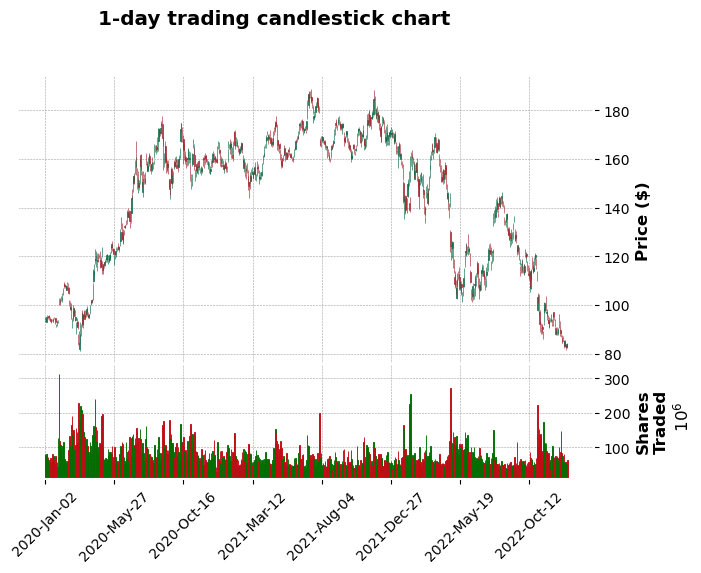

In [ ]:
display_stock_candlestick(data["df"], n=1, title='1-day trading candlestick chart')

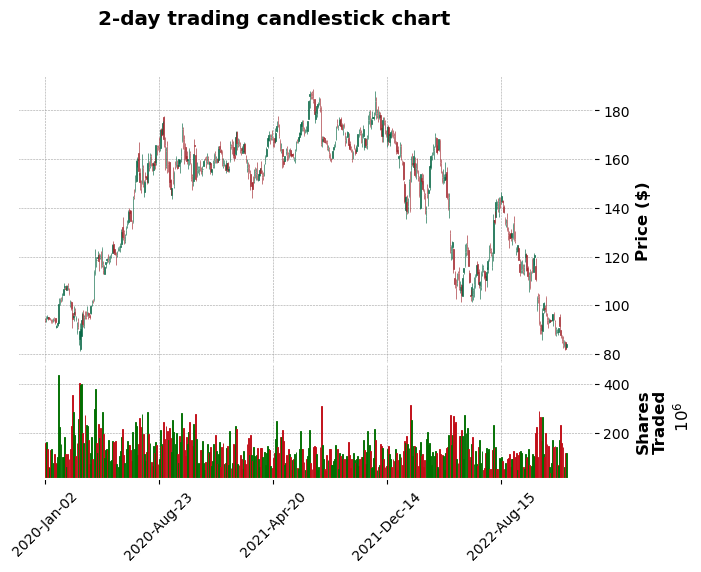

In [ ]:
display_stock_candlestick(data["df"], n=2, title='2-day trading candlestick chart')

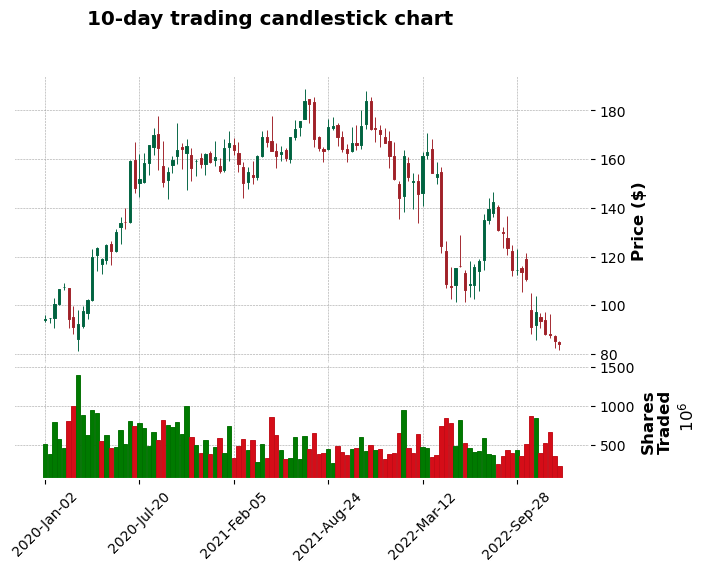

In [ ]:
display_stock_candlestick(data["df"], n=10, title='10-day trading candlestick chart')

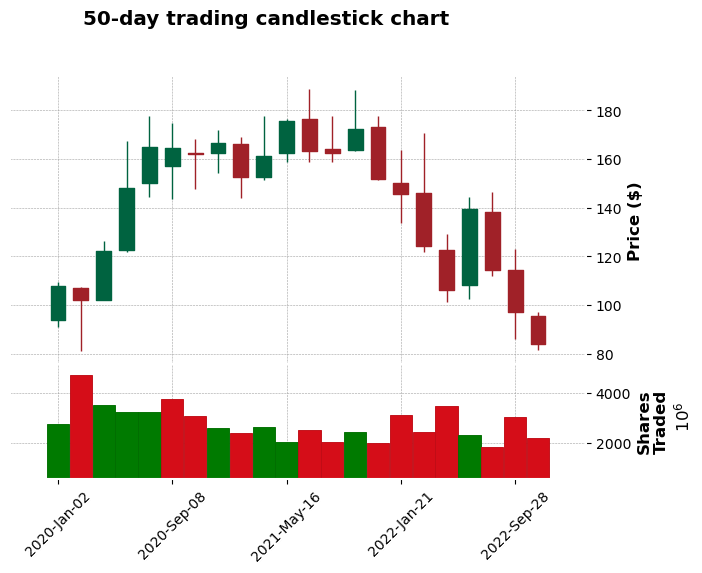

In [ ]:
display_stock_candlestick(data["df"], n=50, title='50-day trading candlestick chart')

# Write a function to display stock market financial data using boxplot chart.
This is particularly useful when you are trying to display your data for a moving window of `n`
consecutive trading days. Again, feel free to use online resources that teach you how to
this but you need to add comments to explain your codes and the parameters you use.

In [ ]:
def plot_stock_boxplot(data, columns, figsize=(10, 7), title='Boxplot for Stock Data'):
    data_show = data[columns]
    plt.figure(figsize=figsize)
    plt.boxplot(data_show.values, labels=columns)
    plt.title(title, fontsize=16)
    plt.ylabel('Values')
    plt.show()


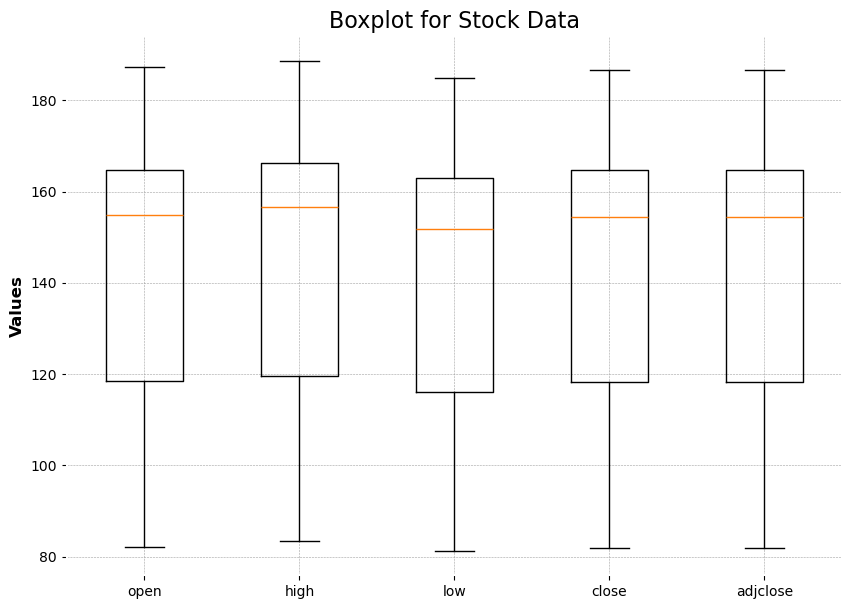

In [ ]:
columns = ['open', 'high', 'low', 'close', 'adjclose']
plot_stock_boxplot(data["df"],columns)

In [ ]:
def plot_moving_window_boxplot(data, columns, n, figsize=(10, 7), title='Boxplot for Stock Data'):
    """
    This function generates a boxplot for the specified stock data over a moving window of n days.

    Parameters:
    data (DataFrame): The entire dataset containing stock data.
    columns (list): The list of column names for which the boxplot will be generated (e.g., 'open', 'high', 'low').
    n (int): The window size (number of days) to use for the boxplot. Must be between 1 and the number of rows in the data.
    figsize (tuple): Optional; the size of the plot (default is (10, 7)).
    title (str): the title of the boxplot (default is 'Boxplot for Stock Data').
    """

    # Check if the window size 'n' is within valid bounds.
    if n < 1 or n > len(data):
        raise ValueError(f"The window size n must be >= 1 and <= the number of rows: {len(data)} in the data.")

    # Extract the first 'n' rows of data for the selected columns to create the moving window.
    window_data = data[columns].iloc[:n]

    # Create a new figure with the specified size for the boxplot.
    plt.figure(figsize=figsize)

    # Generate a boxplot using the values of the selected columns within the moving window.
    plt.boxplot(window_data.values, labels=columns)

    # Set the title of the boxplot, incorporating the window size 'n'.
    plt.title(f'{title}  with {n} days)', fontsize=16)

    # Label the y-axis as 'Values'.
    plt.ylabel('Values')

    # Display the plot.
    plt.show()

# Example usage:
columns = ['open', 'high', 'low', 'close', 'adjclose']

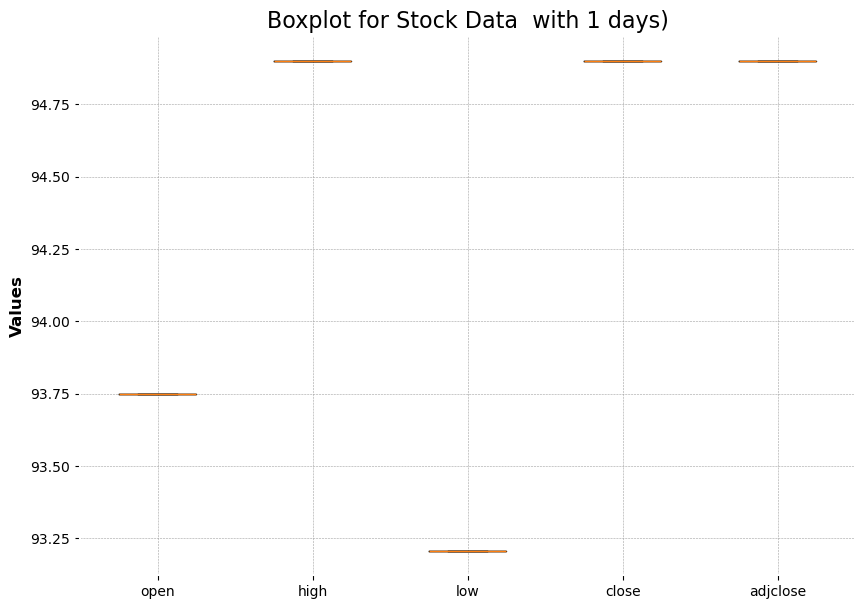

In [ ]:
plot_moving_window_boxplot(data["df"], columns, n=1)

# v0.3: Machine Learning 1

Write a function that takes as input several parameters including the number of layers, the
size of each layer, the layer name and return a Deep Learning model.

Again, our reference project (`P1`) will give you an example of how this can be done.

You can reuse this example, extend it, and most importantly, explain in detail all the code in your program

In [ ]:
target = data["df"][['close']]

target

,close
2020-01-02,94.900497
2020-01-03,93.748497
2020-01-06,95.143997
2020-01-07,95.343002
2020-01-08,94.598503
...,...
2022-12-23,85.250000
2022-12-27,83.040001
2022-12-28,81.820000
2022-12-29,84.180000


In [ ]:
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(target)

scaled_data

array([[0.1248729 ],
       [0.11387533],
       [0.12719746],
       [0.12909727],
       [0.12198991],
       [0.12632397],
       [0.11778462],
       [0.12167009],
       [0.11123575],
       [0.10769398],
       [0.11529304],
       [0.10898278],
       [0.12200418],
       [0.11983715],
       [0.11846241],
       [0.10751263],
       [0.09161771],
       [0.10350785],
       [0.10577517],
       [0.1118276 ],
       [0.17771751],
       [0.17556002],
       [0.19726396],
       [0.1925862 ],
       [0.19753126],
       [0.21139754],
       [0.23747385],
       [0.24553584],
       [0.24992722],
       [0.24509192],
       [0.23793205],
       [0.24786041],
       [0.25480549],
       [0.24663367],
       [0.21936412],
       [0.17798962],
       [0.16054341],
       [0.16381307],
       [0.11832876],
       [0.11806627],
       [0.15157448],
       [0.13011396],
       [0.16201829],
       [0.13729291],
       [0.12634305],
       [0.07838152],
       [0.12191831],
       [0.088

In [ ]:
n_steps = 30 # the days lookback
X, y = create_sequences(scaled_data, n_steps)

X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape

((580, 30, 1), (145, 30, 1))

In [ ]:
y_test.shape

(145,)

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
def build_custom_model(layer_type='LSTM', input_shape=(30, 1), layer_sizes=[50], num_layers=1, dropout=0.2):
    """
    Function to build a custom deep learning model based on provided parameters.

    Parameters:
    layer_type: str - The type of recurrent layer (e.g., 'LSTM', 'GRU', 'RNN').
    input_shape: tuple - Shape of the input data (timesteps, features).
    layer_sizes: list - A list containing the number of units for each layer.
    num_layers: int - The number of recurrent layers to be added to the model.
    dropout: float - Dropout rate to prevent overfitting.

    Returns:
    model: A compiled Keras model.
    """
    model = Sequential()
    # Add the Input layer
    model.add(Input(shape=input_shape))

    # Add recurrent layers based on layer type
    for i in range(num_layers):
        units = layer_sizes[i] if i < len(layer_sizes) else layer_sizes[-1]  # If more layers than sizes, repeat the last size

        if layer_type == 'LSTM':
            model.add(LSTM(units, return_sequences=(i < num_layers - 1)))
        elif layer_type == 'GRU':
            model.add(GRU(units, return_sequences=(i < num_layers - 1)))
        elif layer_type == 'RNN':
            model.add(SimpleRNN(units, return_sequences=(i < num_layers - 1)))

        # Add dropout after each recurrent layer to prevent overfitting
        model.add(Dropout(dropout))

    # add dense layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


In [ ]:
def plot_predict(test, predictions, title='Predicted vs Actual Values'):
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='Actual Values', color='blue', linestyle='--')
    plt.plot(predictions, label='Predicted Values', color='red')

    # Adding title and labels
    plt.title(title)
    plt.xlabel('Observation Number')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
epochs = 50
batch_size = 32

Use the above function to experiment with different DL networks (e.g., LSTM, RNN, GRU,
etc.) and with different hyperparameter configurations (e.g. different numbers of layers and
layer sizes, number of epochs, batch sizes, etc.)

RNN

In [ ]:
model_rnn1 = build_custom_model(layer_type='RNN', input_shape=(30, 1), layer_sizes=[200], num_layers=2, dropout=0.2)
history1 = model_rnn1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.6992 - val_loss: 0.0519
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1460 - val_loss: 0.0212
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0742 - val_loss: 0.0102
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0482 - val_loss: 0.0132
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0756 - val_loss: 0.0037
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0571 - val_loss: 0.0109
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0315 - val_loss: 0.0049
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147 - val_loss: 0.0076
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - val_loss: 0.0026
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - val_loss: 0.0039
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0232 - val_loss: 0.0035
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
23.295938615484857
3.7638960213496753


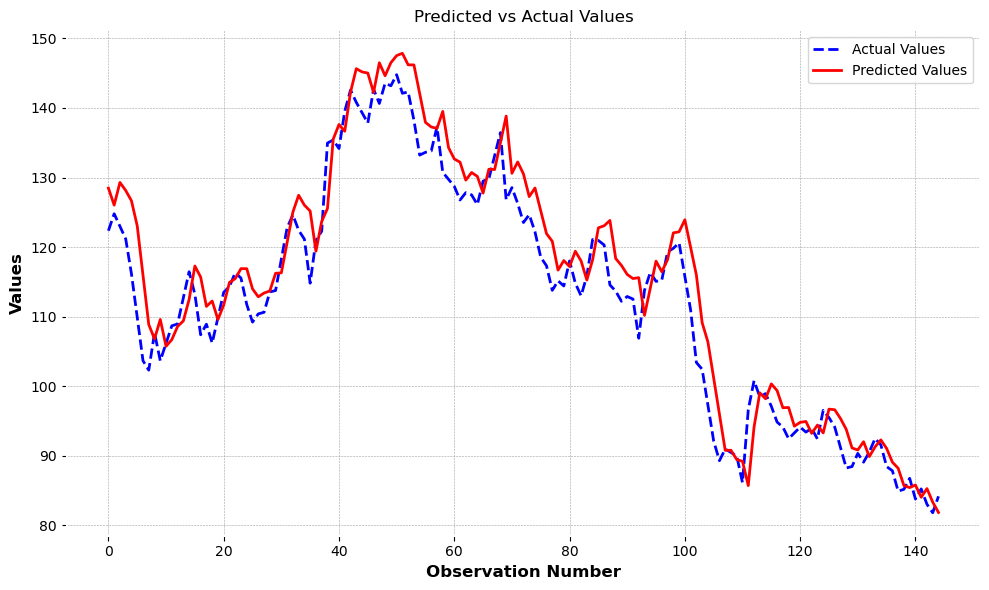

In [ ]:
rnn1_predictions = model_rnn1.predict(X_test)
rnn1_predictions_rescaled = scaler.inverse_transform(rnn1_predictions)
rnn1_mse = mean_squared_error(y_test_scaled, rnn1_predictions_rescaled)
rnn1_mae = mean_absolute_error(y_test_scaled, rnn1_predictions_rescaled)
print(rnn1_mse)
print(rnn1_mae)
plot_predict(y_test_scaled, rnn1_predictions_rescaled, title='Predicted vs Actual Values')

In [ ]:
model_rnn2 = build_custom_model(layer_type='RNN', input_shape=(30, 1), layer_sizes=[50], num_layers=3, dropout=0.3)
history1 = model_rnn2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.5601 - val_loss: 0.0704
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4159 - val_loss: 0.0579
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4013 - val_loss: 0.0089
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3201 - val_loss: 0.0129
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2533 - val_loss: 0.0331
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1952 - val_loss: 0.1121
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1723 - val_loss: 0.0293
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1459 - val_loss: 0.0126
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1089 - val_loss: 0.0245
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1101 - val_loss: 0.0420
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0814 - val_loss: 0.0476
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0831 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
57.8678632150436


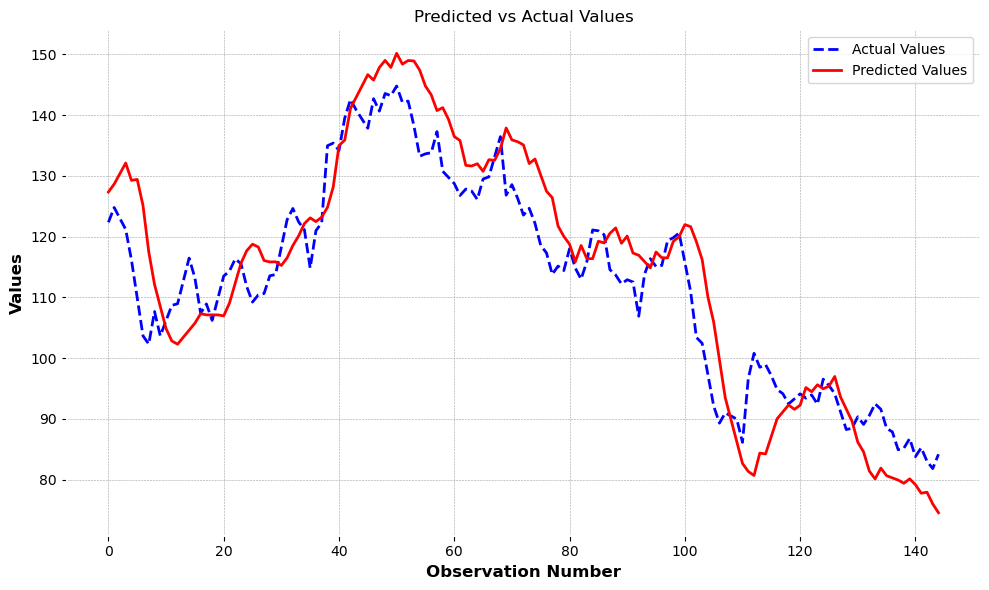

In [ ]:
rnn2_predictions = model_rnn2.predict(X_test)
rnn2_predictions_rescaled = scaler.inverse_transform(rnn2_predictions)
rnn2_mse = mean_squared_error(y_test_scaled, rnn2_predictions_rescaled)
rnn2_mae = mean_absolute_error(y_test_scaled, rnn2_predictions_rescaled)
print(rnn2_mse)
plot_predict(y_test_scaled, rnn2_predictions_rescaled, title='Predicted vs Actual Values')

GRU

In [ ]:
model_gru1 = build_custom_model(layer_type='GRU', input_shape=(30, 1), layer_sizes=[100], num_layers=1, dropout=0.2)
history1 = model_gru1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1299 - val_loss: 0.0614
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0279 - val_loss: 0.0193
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - val_loss: 0.0199
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - val_loss: 0.0165
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
24.9560335258355


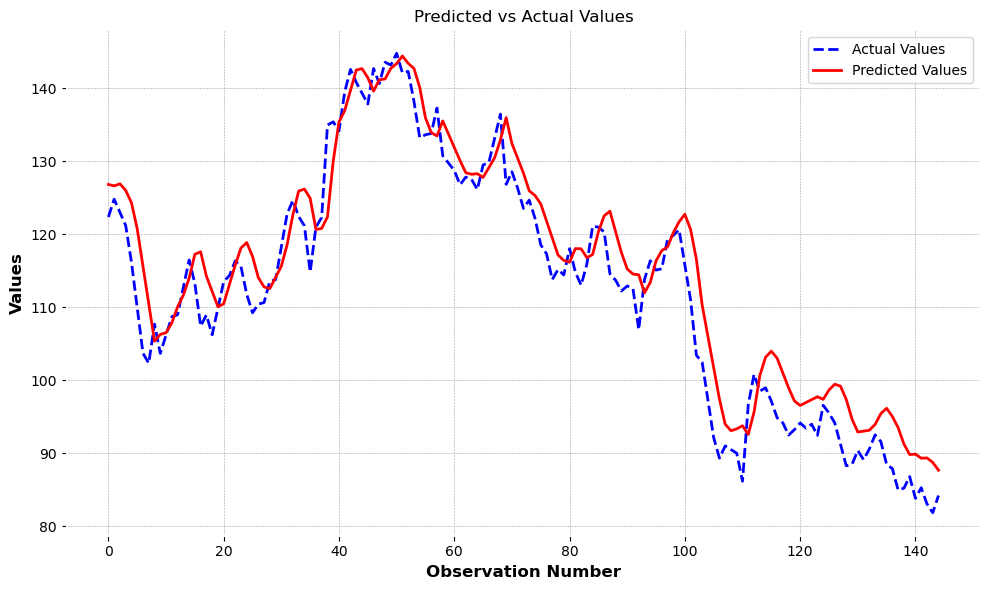

In [ ]:
gru1_predictions = model_gru1.predict(X_test)
gru1_predictions_rescaled = scaler.inverse_transform(gru1_predictions)
gru1_mse = mean_squared_error(y_test_scaled, gru1_predictions_rescaled)
gru1_mae = mean_absolute_error(y_test_scaled, gru1_predictions_rescaled)
print(gru1_mse)
plot_predict(y_test_scaled, gru1_predictions_rescaled, title='Predicted vs Actual Values')

In [ ]:
model_gru2 = build_custom_model(layer_type='GRU', input_shape=(30, 1), layer_sizes=[50], num_layers=3, dropout=0.3)
history1 = model_gru2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0409 - val_loss: 0.0233
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0219 - val_loss: 0.0149
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0210 - val_loss: 0.0118
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0285 - val_loss: 0.0201
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0266 - val_loss: 0.0222
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0229 - val_loss: 0.0187
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0179 - val_loss: 0.0097
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0093 - val_loss: 0.0040
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0091 - val_loss: 0.0039
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step
28.071301213601302


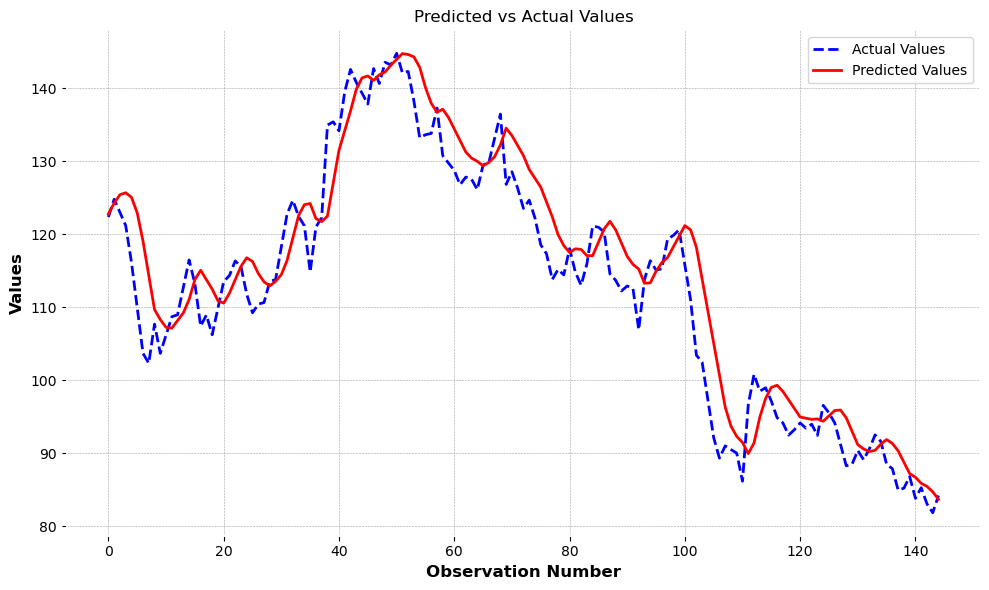

In [ ]:
gru2_predictions = model_gru2.predict(X_test)
gru2_predictions_rescaled = scaler.inverse_transform(gru2_predictions)
gru2_mse = mean_squared_error(y_test_scaled, gru2_predictions_rescaled)
gru2_mae = mean_absolute_error(y_test_scaled, gru2_predictions_rescaled)
print(gru2_mse)
plot_predict(y_test_scaled, gru2_predictions_rescaled, title='Predicted vs Actual Values')

LSTM

In [ ]:
model_lstm1 = build_custom_model(layer_type='LSTM', input_shape=(30, 1), layer_sizes=[200], num_layers=2, dropout=0.2)
history1 = model_lstm1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0134 - val_loss: 0.0092
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0132 - val_loss: 0.0087
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0127 - val_loss: 0.0101
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
36.26392682240672


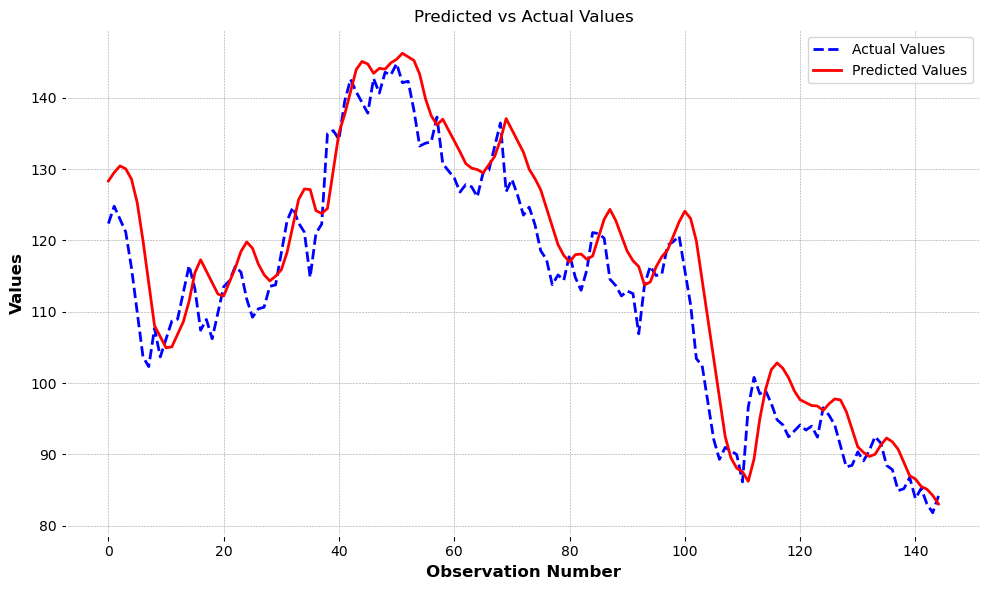

In [ ]:
lstm1_predictions = model_lstm1.predict(X_test)
lstm1_predictions_rescaled = scaler.inverse_transform(lstm1_predictions)
lstm1_mse = mean_squared_error(y_test_scaled, lstm1_predictions_rescaled)
lstm1_mae = mean_absolute_error(y_test_scaled, lstm1_predictions_rescaled)
print(lstm1_mse)
plot_predict(y_test_scaled, lstm1_predictions_rescaled, title='Predicted vs Actual Values')

In [ ]:
model_lstm2 = build_custom_model(layer_type='LSTM', input_shape=(30, 1), layer_sizes=[50], num_layers=3, dropout=0.3)
history1 = model_lstm2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - loss: 0.0643 - val_loss: 0.0203
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0183 - val_loss: 0.0162
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0312 - val_loss: 0.0211
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0400 - val_loss: 0.0514
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0353 - val_loss: 0.0583
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0279 - val_loss: 0.0326
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0189 - val_loss: 0.0151
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0168 - val_loss: 0.0145
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0168 - val_loss: 0.0194
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step


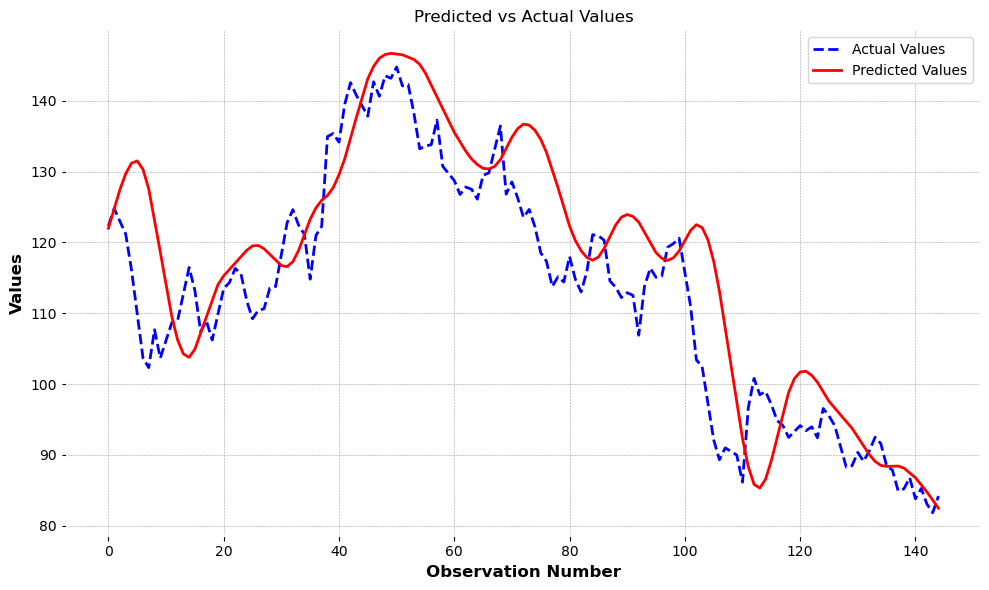

In [ ]:
lstm2_predictions = model_lstm2.predict(X_test)
lstm2_predictions_rescaled = scaler.inverse_transform(lstm2_predictions)
lstm2_mse = mean_squared_error(y_test_scaled, lstm2_predictions_rescaled)
lstm2_mae = mean_absolute_error(y_test_scaled, lstm2_predictions_rescaled)
plot_predict(y_test_scaled, lstm2_predictions_rescaled, title='Predicted vs Actual Values')

## Compare

In [ ]:
df_values = {
    'Model': [],
    'MSE': [],
    'MAE': []
}

# add value
df_values['Model'].append('RNN1')
df_values['MSE'].append(rnn1_mse)
df_values['MAE'].append(rnn1_mae)


df_values['Model'].append('RNN2')
df_values['MSE'].append(rnn2_mse)
df_values['MAE'].append(rnn2_mae)

df_values['Model'].append('GRU1')
df_values['MSE'].append(gru1_mse)
df_values['MAE'].append(gru1_mae)

df_values['Model'].append('GRU2')
df_values['MSE'].append(gru2_mse)
df_values['MAE'].append(gru2_mae)

df_values['Model'].append('LSTM1')
df_values['MSE'].append(lstm1_mse)
df_values['MAE'].append(lstm1_mae)

df_values['Model'].append('LSTM2')
df_values['MSE'].append(lstm2_mse)
df_values['MAE'].append(lstm2_mae)

# Convert to DataFrame
mse_df = pd.DataFrame(df_values)

# Save the DataFrame to CSV
mse_df.to_csv('mae_mse_values.csv', index=False)
mse_df


,Model,MSE,MAE
0,RNN1,23.295939,3.763896
1,RNN2,57.867863,6.145630
2,GRU1,24.956034,4.095152
3,GRU2,28.071301,4.092723
4,LSTM1,36.263927,4.740275
5,LSTM2,81.056690,6.927139


# Machine Learning 2 - v0.5

Develop an ensemble modeling approach consisting of at least two models ARIMA (or SARIMA) and our existing DL model (starting with the LSTM one)

In [ ]:
def parser(x):
 return datetime.strptime('190'+x, '%Y-%m')
X = target.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

Test RMSE: 3.359


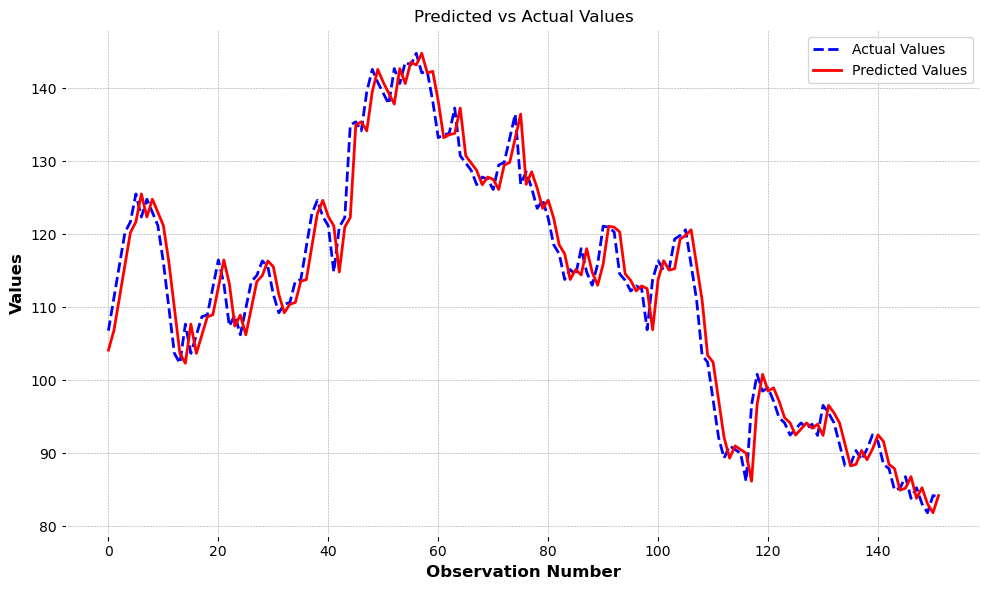

In [ ]:
# Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# evaluate an ARIMA model using a walk-forward validation
# load dataset
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(0,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 arima_predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, arima_predictions))

print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plot_predict(test, arima_predictions, title='Predicted vs Actual Values')

Test RMSE: 5.653


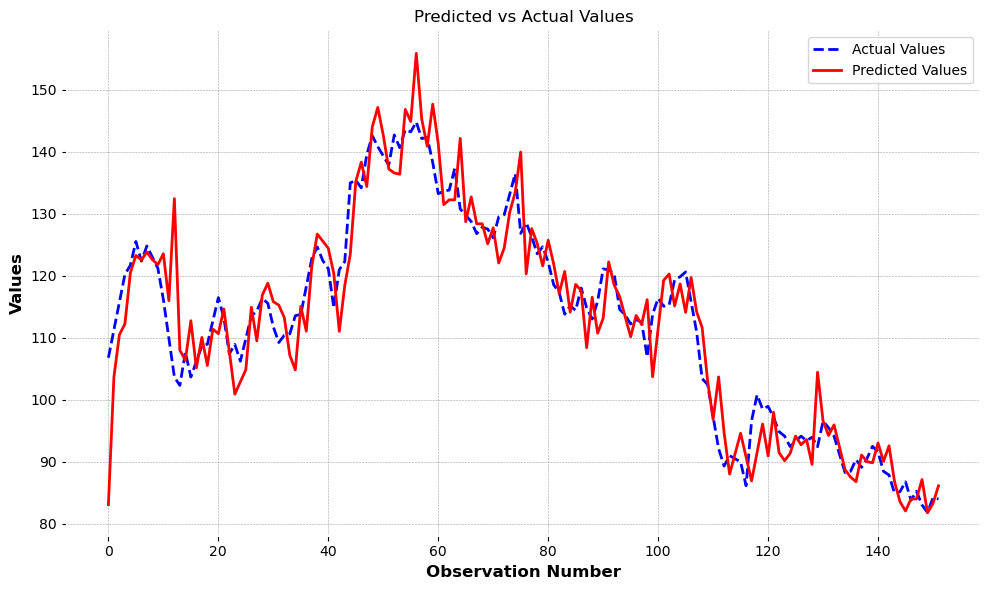

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = SARIMAX(history, order=(0,1,0), seasonal_order=(0,1,0,12))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 sarima_predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, sarima_predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plot_predict(test, sarima_predictions, title='Predicted vs Actual Values')

Epoch 1/50


c:\Users\letri\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4657 
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3464 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2910 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2036 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1426 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0847 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506 
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 
Epoch 16/50
19/

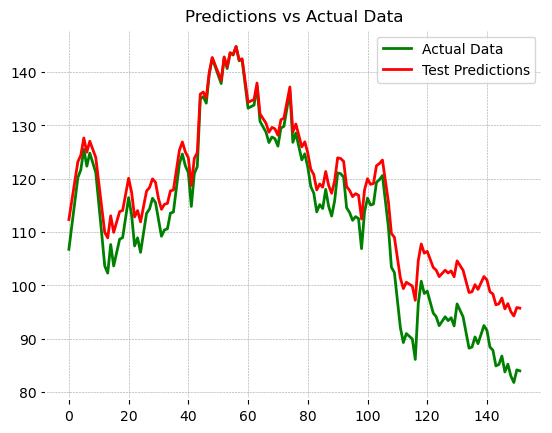

In [ ]:
#Scale the data to (0, 1) range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.reshape(-1, 1))
scaled_test = scaler.transform(test.reshape(-1, 1))

#Reshape data for LSTM [samples, 1 time step, 1 feature]
X_train = scaled_train.reshape(scaled_train.shape[0], 1, 1)
X_test = scaled_test.reshape(scaled_test.shape[0], 1, 1)
y_train = scaled_train
y_test = scaled_test

#Define the LSTM model
model = Sequential()
model.add(LSTM(25, return_sequences=False, input_shape=(1, 1)))  # 1 time step and 1 feature
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)
test_rmse = sqrt(mean_squared_error(y_test, test_predict))
print('Test RMSE: %.3f' % test_rmse)

#Plot the predictions
plt.plot(range(len(test)), test, color='green', label='Actual Data')
plt.plot(range(len(test_predict)), test_predict, color='red', label='Test Predictions')
plt.title('Predictions vs Actual Data')
plt.legend()
plt.show()


In [ ]:
lstm_result = [float(x) for x in test_predict]

C:\Users\letri\AppData\Local\Temp\ipykernel_9420\967610156.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lstm_result = [float(x) for x in test_predict]


In [ ]:
# Convert predictions to numpy arrays if they are not already
arima_predictions = np.array(arima_predictions)
sarima_predictions = np.array(sarima_predictions)
lstm_result = np.array(test_predict).flatten()

# Simple Averaging Ensemble
ensemble_predictions = (arima_predictions + sarima_predictions + lstm_result) / 3

Ensemble Test RMSE: 3.507


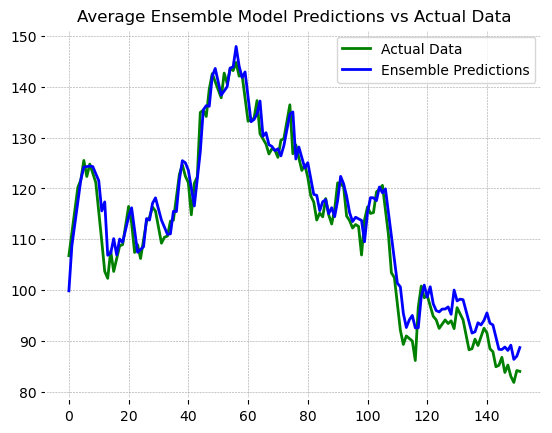

In [ ]:
# Evaluate the Ensemble Predictions
ensemble_rmse = sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'Ensemble Test RMSE: {ensemble_rmse:.3f}')

plt.plot(range(len(y_test)), y_test, label='Actual Data', color='green')
plt.plot(range(len(ensemble_predictions)), ensemble_predictions, label='Ensemble Predictions', color='blue')
plt.title('Average Ensemble Model Predictions vs Actual Data')
plt.legend()
plt.show()

Weighted Ensemble Test RMSE: 3.415


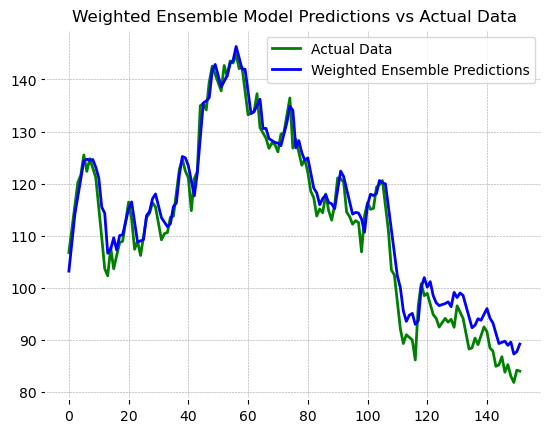

In [ ]:
# Define the weights based on model performance
# Higher weight to models with better performance (lower RMSE)
arima_weight = 0.4
sarima_weight = 0.2
lstm_weight = 0.4

# Weighted Averaging Ensemble
ensemble_predictions_weighted = (arima_weight * arima_predictions +
                                 sarima_weight * sarima_predictions +
                                 lstm_weight * lstm_result)

# Evaluate the Weighted Ensemble Predictions
ensemble_rmse_weighted = sqrt(mean_squared_error(y_test, ensemble_predictions_weighted))
print(f'Weighted Ensemble Test RMSE: {ensemble_rmse_weighted:.3f}')

#  Plot the Weighted Ensemble Predictions vs Actual
plt.plot(range(len(y_test)), y_test, label='Actual Data', color='green')
plt.plot(range(len(ensemble_predictions_weighted)), ensemble_predictions_weighted, label='Weighted Ensemble Predictions', color='blue')
plt.title('Weighted Ensemble Model Predictions vs Actual Data')
plt.legend()
plt.show()

Experiment with different ensemble models (e.g., ARIMA/SARIMA/Random Forrest/LSTM/
RNN/GRU, etc.) and with different hyperparameter configurations.

In [ ]:
data = target[['close']]
data

,close
2020-01-02,94.900497
2020-01-03,93.748497
2020-01-06,95.143997
2020-01-07,95.343002
2020-01-08,94.598503
...,...
2022-12-23,85.250000
2022-12-27,83.040001
2022-12-28,81.820000
2022-12-29,84.180000


In [ ]:
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

n_steps = 30 # the days lookback
X, y = create_sequences(scaled_data, n_steps)

X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape

((580, 30, 1), (145, 30, 1))

In [ ]:
def evaluate_model(y_test, y_pred):
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(y_test, y_pred_rescaled))
    print(f'RMSE: {rmse}')
    return rmse, y_pred_rescaled

In [ ]:
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

RANDOM FOREST

In [ ]:
# Flatten the data for Random Forest
X_train_rf = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_rf = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# Loop over different hyperparameters manually
n_estimators_list = [100, 200, 300]
max_depth_list = [10, 20, 30]

best_rmse_rf = float('inf')
best_params = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        # Train Random Forest with different hyperparameters
        rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf_model.fit(X_train_rf, y_train)
        rf_predictions = rf_model.predict(X_test_rf)
        rf_rmse = sqrt(mean_squared_error(y_test, rf_predictions))
        print(f'n_estimators: {n_estimators}, max_depth: {max_depth}, RMSE: {rf_rmse}')

        # Track the best performing model
        if rf_rmse < best_rmse_rf:
            best_rmse_rf = rf_rmse
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

print(f'Best RF Hyperparameters: {best_params}, Best RMSE: {best_rmse_rf}')

n_estimators: 100, max_depth: 10, RMSE: 0.05619805485885643
n_estimators: 100, max_depth: 20, RMSE: 0.05625890511633933
n_estimators: 100, max_depth: 30, RMSE: 0.05625890511633933
n_estimators: 200, max_depth: 10, RMSE: 0.05552801482519782
n_estimators: 200, max_depth: 20, RMSE: 0.05564414670643148
n_estimators: 200, max_depth: 30, RMSE: 0.05564414670643148
n_estimators: 300, max_depth: 10, RMSE: 0.05553500992736693
n_estimators: 300, max_depth: 20, RMSE: 0.05577380299246915
n_estimators: 300, max_depth: 30, RMSE: 0.05577380299246915
Best RF Hyperparameters: {'n_estimators': 200, 'max_depth': 10}, Best RMSE: 0.05552801482519782


RMSE: 5.816587089873092


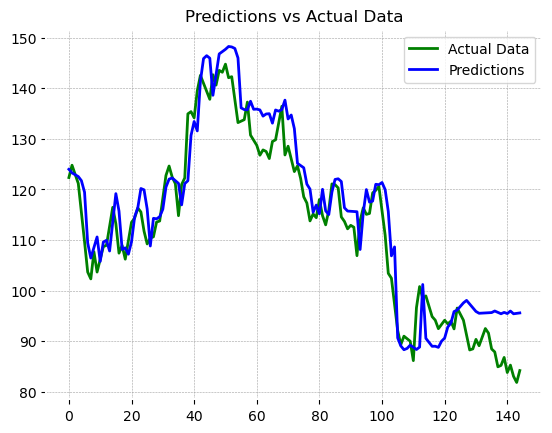

In [ ]:
best_rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
best_rf_model.fit(X_train_rf, y_train)

best_rf_predictions = best_rf_model.predict(X_test_rf)
best_rf_rmse , best_rf_predictions_rescaled= evaluate_model(y_test_rescaled, best_rf_predictions)

# Plot Actual vs Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_rf_predictions_rescaled, label='Predictions', color='blue')
plt.title('Predictions vs Actual Data')
plt.legend()
plt.show()

LSTM

In [ ]:
import keras_tuner as kt

# Define the model-building function for Keras Tuner
def build_lstm_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(n_steps, 1))) # 4 units
    model.add(Dense(1))

    # Tune the learning rate
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error') # 2 optimizers

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10, # 4 units * 2 optimizers = 8 trials, if trails more than max trails, it will stop the search when above the max trails 
    executions_per_trial=1,
    directory='tuner_results',
    project_name='lstm_tuning'
)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(f'Best Hyperparameters: {best_hp.values}')

Trial 8 Complete [00h 00m 20s]
val_loss: 0.002538818633183837

Best val_loss So Far: 0.0015758618246763945
Total elapsed time: 00h 03m 13s
Best Hyperparameters: {'units': 200, 'optimizer': 'rmsprop'}


Epoch 1/50


c:\Users\letri\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1494 - val_loss: 0.0275
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - val_loss: 0.0065
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0074 - val_loss: 0.0084
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0103
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - val_loss: 0.0158
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038 - val_loss: 0.0094
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 0.0063
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - val_l

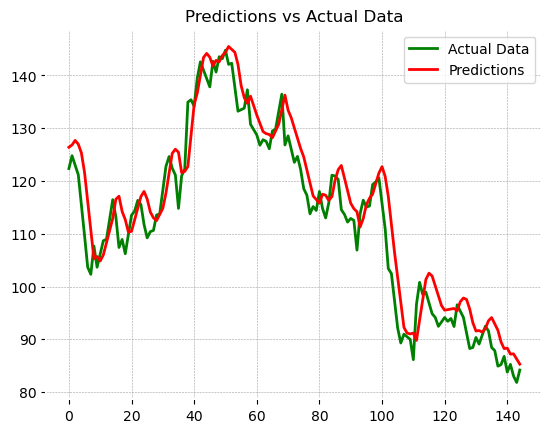

In [ ]:
# Best hyperparameters from the tuner
best_units = 200
best_optimizer = 'rmsprop'

best_lstm_model = Sequential()
best_lstm_model.add(LSTM(best_units, input_shape=(n_steps, 1)))
best_lstm_model.add(Dense(1))
best_lstm_model.compile(optimizer=best_optimizer, loss='mean_squared_error')
best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))
best_lstm_predictions = best_lstm_model.predict(X_test)

# Evaluate the final model

best_lstm_rmse, best_lstm_predictions_rescaled = evaluate_model(y_test_rescaled, best_lstm_predictions)

# Plot Actual vs LSTM Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_lstm_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()


GRU

In [ ]:
# Define the model-building function for Keras Tuner
def build_gru_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(GRU(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(n_steps, 1)))
    model.add(Dense(1))

    # Tune the learning rate or optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')

    return model

# Initialize the tuner
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_gru',
    project_name='gru_tuning'
)

# Run the search
tuner_gru.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the optimal hyperparameters
best_hp_gru = tuner_gru.get_best_hyperparameters()[0]
print(f'Best GRU Hyperparameters: {best_hp_gru.values}')


Trial 8 Complete [00h 00m 24s]
val_loss: 0.0012688779970631003

Best val_loss So Far: 0.0012316388310864568
Total elapsed time: 00h 02m 41s
Best GRU Hyperparameters: {'units': 150, 'optimizer': 'rmsprop'}


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1497 - val_loss: 0.0257
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051 - val_loss: 0.0123
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0070
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

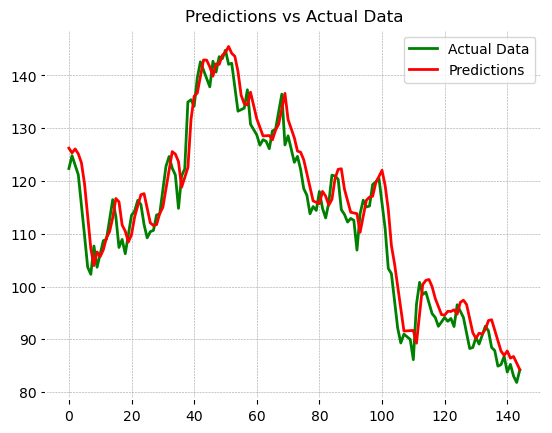

In [ ]:
# Best hyperparameters from the tuner
best_units_gru = 150
best_optimizer_gru = 'rmsprop'

best_gru_model = Sequential()
best_gru_model.add(GRU(best_units_gru, input_shape=(n_steps, 1)))
best_gru_model.add(Dense(1))
best_gru_model.compile(optimizer=best_optimizer_gru, loss='mean_squared_error')
best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

best_gru_predictions = best_gru_model.predict(X_test)

# Evaluate the final model
best_gru_rmse, best_gru_predictions_rescaled = evaluate_model(y_test_rescaled, best_gru_predictions)

# Plot Actual vs LSTM Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_gru_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()

RNN

In [ ]:
# Define the model-building function for Keras Tuner
def build_rnn_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(SimpleRNN(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(n_steps, 1)))
    model.add(Dense(1))

    # Tune the learning rate or optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# Initialize the tuner for RNN
tuner_rnn = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_rnn',
    project_name='rnn_tuning'
)

# Run the search
tuner_rnn.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get the optimal hyperparameters
best_hp_rnn = tuner_rnn.get_best_hyperparameters()[0]
print(f'Best RNN Hyperparameters: {best_hp_rnn.values}')


Trial 8 Complete [00h 00m 10s]
val_loss: 0.001200784114189446

Best val_loss So Far: 0.001112928963266313
Total elapsed time: 00h 01m 31s
Best RNN Hyperparameters: {'units': 200, 'optimizer': 'rmsprop'}


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4058 - val_loss: 0.0089
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0353 - val_loss: 0.0239
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0322
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0557 - val_loss: 0.0054
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0048
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 - val_loss: 0.0026
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_l

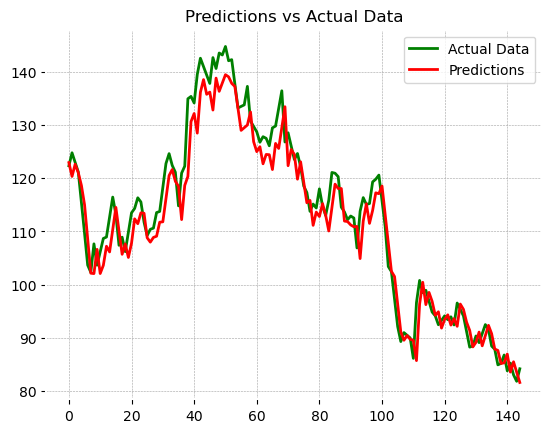

In [ ]:
# Best hyperparameters from the tuner
best_units_rnn = 200
best_optimizer_rnn = 'rmsprop'

# Define the final RNN model with the best hyperparameters
best_rnn_model = Sequential()
best_rnn_model.add(SimpleRNN(best_units_rnn, input_shape=(n_steps, 1)))
best_rnn_model.add(Dense(1))
best_rnn_model.compile(optimizer=best_optimizer_rnn, loss='mean_squared_error')
best_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

best_rnn_predictions = best_rnn_model.predict(X_test)
best_rnn_rmse, best_rnn_predictions_rescaled = evaluate_model(y_test_rescaled, best_rnn_predictions)

# Plot Actual vs LSTM Predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_rnn_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()

In [ ]:
def evaluate_model(y_test, y_pred):
    #y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')
    return rmse, y_pred

In [ ]:
best_lstm = np.array(best_lstm_predictions_rescaled).flatten()
best_gru = np.array(best_gru_predictions_rescaled).flatten()
best_rnn = np.array(best_rnn_predictions_rescaled).flatten()
best_rf = np.array(best_rf_predictions_rescaled).flatten()

RMSE: 3.9712084559060092


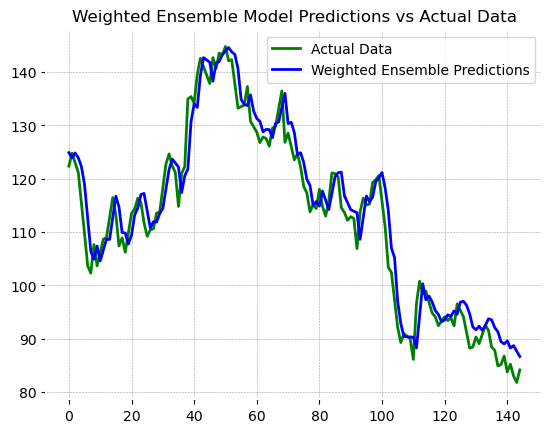

In [ ]:
# Simple Averaging Ensemble (take the mean of the four models)
ensemble_predictions = (best_rnn + best_rf + best_gru + best_lstm) / 4

# Evaluate the Weighted Ensemble Predictions
ensemble_rmse_avg, ensemble_prediction_rescaled = evaluate_model(y_test_rescaled, ensemble_predictions)

#  Plot the Weighted Ensemble Predictions vs Actual
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual Data', color='green')
plt.plot(range(len(ensemble_prediction_rescaled)), ensemble_prediction_rescaled, label='Weighted Ensemble Predictions', color='blue')
plt.title('Weighted Ensemble Model Predictions vs Actual Data')
plt.legend()
plt.show()

In [ ]:
rmse = [best_rf_rmse, best_lstm_rmse, best_gru_rmse, best_rnn_rmse]
rmse

[5.816587089873092, 4.890835931353441, 4.128703274761103, 4.055255841119359]

In [ ]:
rmse = np.array([best_rf_rmse, best_lstm_rmse, best_gru_rmse, best_rnn_rmse])
inverse_rmse = 1 / rmse
weights = inverse_rmse / np.sum(inverse_rmse)
rf_weight, lstm_weight, gru_weight, rnn_weight = weights

RMSE: 3.8700937865101803


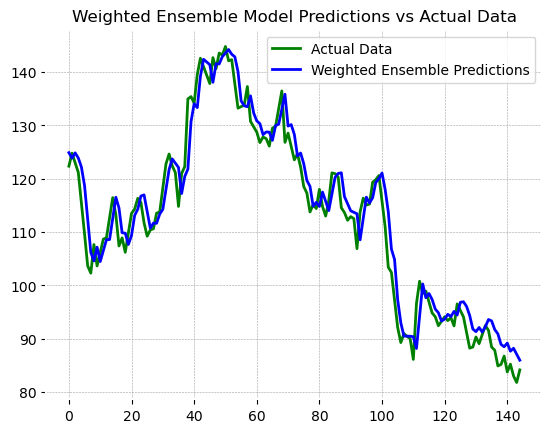

In [ ]:
# Weighted Averaging Ensemble
ensemble_predictions_weighted = (best_lstm * lstm_weight +
                                 best_gru * gru_weight +
                                 best_rnn * rnn_weight +
                                 best_rf * rf_weight)

# Evaluate the Weighted Ensemble Predictions
ensemble_rmse_weighted, ensemble_prediction_rescaled = evaluate_model(y_test_rescaled, ensemble_predictions_weighted)

#  Plot the Weighted Ensemble Predictions vs Actual
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label='Actual Data', color='green')
plt.plot(range(len(ensemble_prediction_rescaled)), ensemble_prediction_rescaled, label='Weighted Ensemble Predictions', color='blue')
plt.title('Weighted Ensemble Model Predictions vs Actual Data')
plt.legend()
plt.show()